In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Colaborative Filtering

### Creating Dataloaders

In [2]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [3]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user', 'movie', 'rating', 'timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie', 'title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [5]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [6]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs = 64)
# user column is already specified in the df; will be autodetected
dls.show_batch()

,user,title,rating
0,468,Contact (1997),4
1,899,Henry V (1989),4
2,618,Speed (1994),4
3,753,"Shawshank Redemption, The (1994)",4
4,118,Copycat (1995),2
5,494,What's Eating Gilbert Grape (1993),5
6,452,Pinocchio (1940),4
7,417,Star Trek: First Contact (1996),3
8,145,Boxing Helena (1993),2
9,286,Year of the Horse (1997),5


In [7]:
n_users= len(dls.classes['user'])
n_movies= len(dls.classes['title'])
n_factors= 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [8]:
user_factors.shape, movie_factors.shape

(torch.Size([944, 5]), torch.Size([1665, 5]))

In [9]:
# To calc the result of particular movie and user combination
# we have to to look up the index of the movie in our movie latent factor matrix
# similarly, we have to do it for user
# Getting user 3 latent factors
one_hot_3 = one_hot(3, n_users).float() # Creating one hot encoding vector
print(one_hot_3.shape)
user_factors.T @ one_hot_3

torch.Size([944])


tensor([-0.7807, -0.5311,  0.3496, -0.4182, -0.4670])

In [10]:
user_factors[3] # It gives us the same vector as the one at index3 in the matrix

tensor([-0.7807, -0.5311,  0.3496, -0.4182, -0.4670])

In [11]:
# Trying with multiple users
one_hot_0= one_hot(0, n_users).float()
one_hot_1= one_hot(1, n_users).float()
one_hot_2= one_hot(2, n_users).float()
index_012 = torch.stack((one_hot_0, one_hot_1, one_hot_2))
index_012, index_012.shape

(tensor([[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.]]),
 torch.Size([3, 944]))

In [12]:
index_012 @ user_factors

tensor([[-0.1703,  0.1062,  0.3494,  1.9831, -1.1991],
        [ 0.0548, -0.2849, -0.2806,  0.8618,  0.9572],
        [-2.0020, -0.3290,  0.6626,  0.0169,  0.8489]])

- This would be a perfectly acceptable way to build models using this kind of architecture, except that it would use a lot more memory and time than necessary.
- we know that there is no real underlying reason to store the one-hot-encoded vector, or to search through it to find the occurrence of the number one—we should just be able to index into an array directly with an integer. 
>  Therefore, most deep learning libraries, including PyTorch, include a special layer that does just this; it indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector. This is called an embedding.

In [13]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
    
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users*movies).sum(dim=1)

In [14]:
x, y = dls.one_batch()
x.shape, x, y

(torch.Size([64, 2]),
 tensor([[ 210, 1457],
         [  10,  937],
         [ 655,  689],
         [ 210, 1182],
         [ 151, 1534],
         [  97,  619],
         [ 234, 1205],
         [ 629,  201],
         [ 515, 1275],
         [ 578,  294],
         [ 782,   73],
         [ 458, 1075],
         [ 286,  464],
         [ 737, 1302],
         [ 456,  499],
         [ 270, 1404],
         [ 881,   51],
         [ 189,  881],
         [ 103,  552],
         [ 495,  144],
         [ 313,  775],
         [ 389,  760],
         [ 453, 1645],
         [ 881,  988],
         [  87,  892],
         [ 888,  529],
         [ 246, 1375],
         [ 711,  132],
         [ 405, 1179],
         [ 545,  548],
         [ 367, 1612],
         [ 537, 1475],
         [ 665,  471],
         [ 334,  573],
         [ 293, 1210],
         [ 634,  210],
         [  94,  927],
         [ 130,  525],
         [ 497,  617],
         [ 109,  289],
         [ 819,   33],
         [ 521,  965],
         [ 2

In [15]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [16]:
model.user_factors, model.user_factors

(Embedding(944, 50), Embedding(944, 50))

In [17]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.316934,1.298450,00:10
1,1.082428,1.100338,00:09
2,0.953002,0.968825,00:09
3,0.859348,0.884143,00:09
4,0.796893,0.865430,00:09


### Adding Non Linearity
Adding prediction range limiter

In [18]:
# Improving model by adding non linearity 
# so that the prediction range is in the desired range
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        return sigmoid_range((users*movies).sum(dim=1), *self.y_range)

In [19]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func = MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.992412,1.001378,00:09
1,0.878010,0.891201,00:09
2,0.648862,0.863972,00:10
3,0.466892,0.873099,00:09
4,0.363910,0.877090,00:09


### Adding Bias Factor
- Adding Bias so that we can adjust the missing piece which is that some users are just more positive or negative in their recommendations than others, and some movies are just plain better or worse than others
- We don't have any way of representing it in the dot product table.
> We can represent that how much the action it contains, is it sci-fi, is it old... but there's no way to represent that movie is generally percieved ie, liked/disliked by everyone
Similarly, whether user prefers watching movies and liking them or not.

In [20]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 55)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
    def forward(self, x):
        users = self.user_factors(x[:, 0])
        movies = self.movie_factors(x[:, 1])
        res = (users*movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [21]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,7.578275,5.533803,00:10
1,2.224777,2.116163,00:10
2,1.394541,1.585827,00:10
3,0.961300,1.280849,00:10
4,0.775323,1.209450,00:10


## Preventing Overfitting
### Weight Decay or L2 Regularisation
- Adding sum of the square of the weight to the loss function
- To penalize the model for carrying larger weights
- Resulting in less sparse network and pushes the prediction towards the underfitting

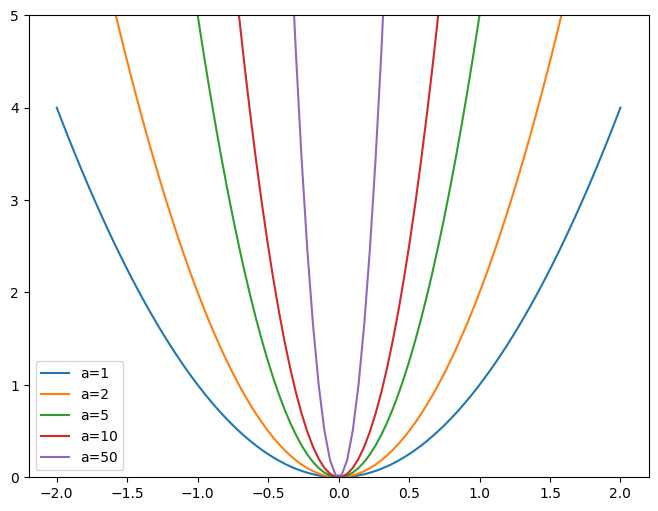

In [22]:
x = np.linspace(-2,2,100)
a_s = [1,2,5,10,50] 
ys = [a * x**2 for a in a_s]
_,ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim([0,5])
ax.legend();
# This shows that having higher weights gives the model better flexibility
# and allows it to overfit 

- letting our model learn high parameters might cause it to fit all the data points in the training set with an overcomplex function that has very sharp changes, which will lead to overfitting.
- Limiting our weights from growing too much is going to hinder the training of the model, but it will yield a state where it generalizes better.
- weight decay (or just wd) is a parameter that controls that sum of squares we add to our loss (assuming parameters is a tensor of all parameters)

> loss_with_wd = loss + wd * (parameters**2).sum()

or we can directly modify the parameters grad with the derivative of the L2 regularization calculation

> parameters.grad += wd * 2 * x

In [23]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.05)

epoch,train_loss,valid_loss,time
0,7.619683,6.039255,00:10
1,2.460578,2.237838,00:10
2,1.550322,1.790362,00:10
3,1.057854,1.436298,00:10
4,0.931362,1.356359,00:10
